## Class 5: Intro to Computational Linguistics for Cultural Analytics

This is a custom made tutorial, written by Professor Douglas Guilbeault for his class on People Analytics
at the Haas School of Business. February 2021. 

### Emphasis: Word Embedding Models for Cultural Analytics

This notebook will measure cultural associations in language using Kozlowski et al's Geometries of Culture Method.
This method uses word2vec, a word embedding model, to identify implicit cultural dimensions (e.g. gender) that allow us to see how words (e.g. occupations, brands) are associated with cultural features (e.g. gender or morality. 

References:
Kozlowski, Austin C., Matt Taddy, and James A. Evans. “The Geometry of Culture: Analyzing the Meanings of Class through Word Embeddings.” American Sociological Review 84, no. 5 (October 1, 2019): 905–49. https://doi.org/10.1177/0003122419877135.

NOTE: for this notebook to work, you will need to download this file "GoogleNews-vectors-negative300.bin" (e.g. from here, https://github.com/mmihaltz/word2vec-GoogleNews-vectors) and you will need to place this file in the same folder as you place this notebook. This file contains a word embedding model pre-trained on the corpus of Google books. 

In [1]:
import scipy
import gensim
import scipy
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

### Define our functions

As a beginner to Python, you won't need to know how these work. 

In [2]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [3]:
def process_inputs(model, dimension, dimension_name, word_list):
    g = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dimension.reshape(1,-1))[0][0])
    df = pandas.DataFrame({dimension_name: g}, index = word_list)
    return df

In [45]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim, title):
    ax.set_frame_on(False)
    ax.set_title(title, fontsize = 12)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.8, fontsize = 15)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

### Now let's run the model

#### First, we will load the pre-trained word2vec embedding space based on Google News

In [5]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
##Run the following commands below to see all the datasets available
##These include: Twitter, Wikipedia, and the General Internet Crawl

#import gensim.downloader #load library for downloading language models for different datasets in gensim
#print(list(gensim.downloader.info()['models'].keys()))#show all datasets preloaded into gensim


#### Let's use a quick analogy to test our model

In [6]:
model.most_similar(positive=['king'], topn=5)

[('kings', 0.7138045430183411),
 ('queen', 0.6510956883430481),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204219460487366),
 ('prince', 0.6159993410110474)]

In [7]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

##### Next, we will build the cultural dimensions we're interested. For example, let's create a 'gender' dimensions

In [46]:
Gender = dimension(model, ['man','him','he', 'male', 'boy'], ['woman', 'her', 'she', 'female', 'girl'])

##### Now, let's look at the different concepts we want to examine along the gender dimension

In [47]:
Occupations = ["CEO", "banker","engineer", "carpenter","entrepreneur",
               "hairdresser", "nanny","assistant","nurse", "secretary", "intern"]
Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]
Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

In [48]:
Occupations_output = process_inputs(model=model, dimension=Gender, dimension_name='gender', word_list=Occupations) 
Food_output = process_inputs(model=model, dimension=Gender, dimension_name='gender', word_list=Foods)
Sports_output = process_inputs(model=model, dimension=Gender, dimension_name='gender', word_list=Sports)

#### Let's look at how 'occupations' fall along this gender dimension

In [49]:
#Occupations_output
Occupations_output.sort_values(by=['gender'])

,gender
nurse,-0.275027
hairdresser,-0.229392
nanny,-0.176223
intern,-0.127041
secretary,-0.059173
assistant,-0.019041
entrepreneur,0.037492
banker,0.046643
CEO,0.078593
engineer,0.103626


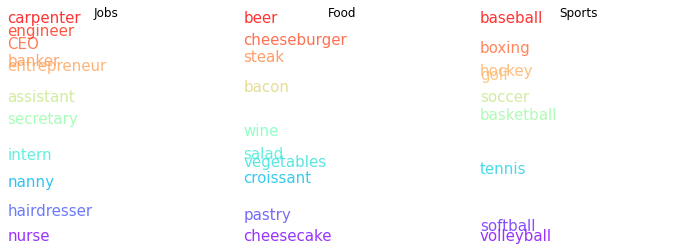

In [51]:
#appearing high on the plot indicates that a word falls on the male side of the gender dimensions
#appearing low on the plot indicates that a word falls on the female side of the gender dimensions

fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Occupations_output, 'gender', 'Jobs')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Food_output, 'gender', 'Food')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sports_output, 'gender', 'Sports')
plt.show()


##### Now, let's construct another dimension we're interested in. This time let's make a moral dimension

In [52]:
Moral = dimension(model,['good','moral','kind', 'trustworthy', 'honest', 'selfless'], 
                  ['bad', 'immoral', 'unkind', 'untrustworthy', 'deceitful', 'selfish'])

In [53]:
test_categories  = ["villian", "hero"]
Companies  = ["Google", "Facebook", "Twitter", "IBM", "Amazon", "Microsoft", 
              "Airbnb", "Pepsi", "Pfizer", "CocaCola","Monsanto", "Tyson"]

In [54]:
Companies_output = process_inputs(model=model, dimension=Moral, dimension_name='Moral', word_list=Companies) 
test_categories_output = process_inputs(model=model, dimension=Moral, dimension_name='Moral', word_list=test_categories) 

In [55]:
test_categories_output.sort_values(by=['Moral'])
#Companies_output.sort_values(by=['Moral'])

,Moral
villian,-0.156436
hero,0.070267


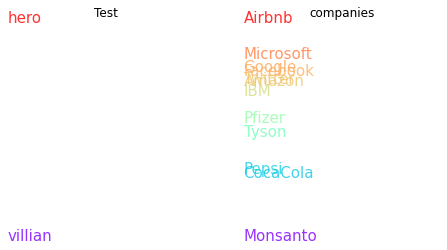

In [56]:
#appearing high on the plot indicates that a word falls on the male side of the gender dimensions
#appearing low on the plot indicates that a word falls on the female side of the gender dimensions

fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, test_categories_output, 'Moral', 'Test')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Companies_output, 'Moral', "companies")

plt.show()


In [65]:
tech_companies  = ["Google", "Facebook", "Twitter", "Microsoft", "Apple", "SpaceX"]

In [66]:
Competitive = dimension(model, ['winner', 'rich', 'success'], ['loser', 'poor', 'failure'])

In [67]:
tech_companies_competitive_df = process_inputs(model=model, dimension=Competitive, dimension_name='Competitive', word_list=tech_companies) 

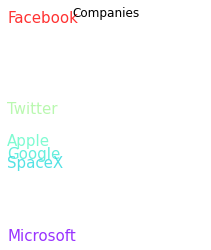

In [68]:
#appearing high on the plot indicates that a word falls on the male side of the gender dimensions
#appearing low on the plot indicates that a word falls on the female side of the gender dimensions

fig = plt.figure(figsize = (12,4))
ax2 = fig.add_subplot(132)
PlotDimension(ax2, tech_companies_competitive_df, 'Competitive', 'Companies')

plt.show()
